In [1]:
import time
import warnings
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import pandas as pd
import polars as pl
pl.enable_string_cache(True)

warnings.filterwarnings('ignore')

from feature_engine.encoding import OrdinalEncoder
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor

seed=42

In [2]:
(
    pl.scan_parquet("../datasets/19_model/train.zstd")
    .groupby('DISTRICT')
    .agg(pl.col('GEOHASH').n_unique())
    .sort('GEOHASH')
    .collect(streaming=True)
)

DISTRICT,GEOHASH
cat,u32
"""Beylikdüzü""",14
"""Güngören""",15
"""Sultanbeyli""",17
"""Beyoğlu""",18
"""Gaziosmanpaşa""",18
"""Zeytinburnu""",19
"""Bayrampaşa""",19
"""Şişli""",21
"""Kâğıthane""",26


In [3]:
def get_train(district):
    
    df = (
        pl.concat([
            (
                pl.read_parquet("../datasets/19_model/train.zstd")
                .filter(pl.col('DISTRICT').eq(district))
                .with_columns(pl.col('GEOHASH')
                            .cast(pl.Utf8)
                            .cast(pl.Categorical))
            ),
            (
                pl.read_parquet("../datasets/19_model/valid.zstd")
                .filter(pl.col('DISTRICT').eq(district))
                .with_columns(pl.col('GEOHASH')
                            .cast(pl.Utf8)
                            .cast(pl.Categorical))
            )
        ], how='vertical')
        .drop('DISTRICT')
        .sort(['DATE_TIME', 'GEOHASH'])
        .to_pandas()
        .set_index('DATE_TIME')
    )

    return df

In [4]:
def create_pipeline(train):
    cat_cols = [col for col in train.columns if train[col].dtype=='category']
    time_cols = ["month", "day_of_month", "hour", "day_of_week"] #excluding year

    # Extract date time features
    dt_feats=DatetimeFeatures(variables='index', features_to_extract = ["year", "month", "day_of_month", "hour", "day_of_week"])

    # Encode categorical columns with numbers.
    ord_encoder=OrdinalEncoder(encoding_method='arbitrary', variables=cat_cols)

    # Convert time features such as day, month, hour and day of week to cyclical features to maintain cyclicity.
    cf_encoder=CyclicalFeatures(variables=time_cols, drop_original=True)


    # LGBM
    lgbm_params = {'n_estimators': 266, 
                   'num_leaves': 87,
                   'colsample_bytree': 0.676,
                   'learning_rate': 0.0223, 
                   'max_depth': 6, 
                   'reg_alpha': 2.3, 
                   'reg_lambda': 0.011, 
                   'min_child_weight': 0.0017}

    lgbm=LGBMRegressor(**lgbm_params, n_jobs=-1, random_state=seed)

    #Creating encoder pipeline
    pipeline = make_pipeline(
        (dt_feats), # Extract date time features
        (ord_encoder), # Ordinal Encoder
        (cf_encoder), # Cyclical Feature
        (lgbm) # LGBMregressor
    )

    return pipeline

In [5]:
# https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.9 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [6]:
def cv_train(pipeline, train):

    X_df = train.drop('NUMBER_OF_VEHICLES', axis=1)
    y_df = train['NUMBER_OF_VEHICLES']

    tss = BlockingTimeSeriesSplit(n_splits=5)

    rmse_values = []

    count = 1
    # Loop through the folds
    print("Cross Validating.....")
    print()

    # start timer
    loop_time = time.time()

    for train_index, test_index in tss.split(X_df, y_df):

        X_train_cv, X_test_cv = X_df.iloc[train_index], X_df.iloc[test_index]
        y_train_cv, y_test_cv = y_df.iloc[train_index], y_df.iloc[test_index]

        # Fit the model on the train data
        pipeline.fit(X_train_cv, y_train_cv)

        # Predict on the test data
        y_pred = np.round(pipeline.predict(X_test_cv))

        # Calculate the mean squared error
        rmse = mean_squared_error(y_test_cv, y_pred, squared=False)

        print(f"cv #{count}: RMSE = {rmse:.3f} | Time taken: {(time.time() - loop_time)/60:.2f} min")

        rmse_values.append(rmse)
        count += 1
        loop_time = time.time()
        
    # Print the average MSE over all folds
    print()
    print(f"Average RMSE: {np.mean(rmse_values):.3f} ± {np.std(rmse_values):.2f}")

    return pipeline

In [7]:
def plot_cv_results(pipeline, district):
    
    feat_scores=pipeline.steps[-1][-1].feature_importances_
    feat_names=pipeline.steps[-1][-1].feature_name_

    #Creating a dataframe for feature importance
    feat_imp_df = (
        pd.DataFrame({'features' : feat_names,'importance' : np.abs(np.round(feat_scores, 3))})
        .set_index('features').sort_values('importance')
    )
    
    #Plot
    ax = feat_imp_df.plot(kind='barh', edgecolor='k', figsize=(3, 20))
    ax.bar_label(ax.containers[0], fontsize=13, padding=3);
    ax.legend().remove()
    ax.set_title(f"{district} Local Model Feature Importance")
    
    plt.show();

Başakşehir
Cross Validating.....

cv #1: RMSE = 26.202 | Time taken: 0.16 min
cv #2: RMSE = 23.573 | Time taken: 0.16 min
cv #3: RMSE = 24.721 | Time taken: 0.16 min
cv #4: RMSE = 24.611 | Time taken: 0.16 min
cv #5: RMSE = 31.666 | Time taken: 0.17 min

Average RMSE: 26.155 ± 2.88


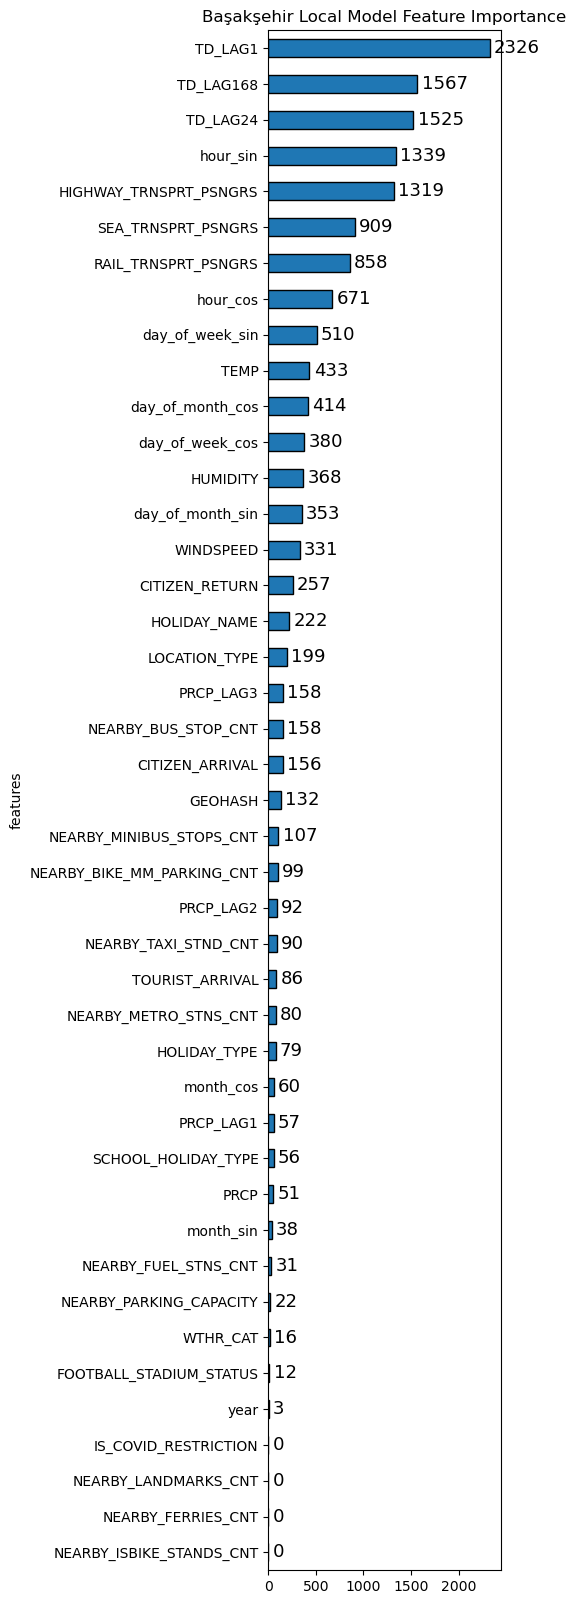



Beşiktaş
Cross Validating.....

cv #1: RMSE = 20.306 | Time taken: 0.11 min
cv #2: RMSE = 17.763 | Time taken: 0.08 min
cv #3: RMSE = 23.434 | Time taken: 0.09 min
cv #4: RMSE = 20.556 | Time taken: 0.09 min
cv #5: RMSE = 24.686 | Time taken: 0.08 min

Average RMSE: 21.349 ± 2.45


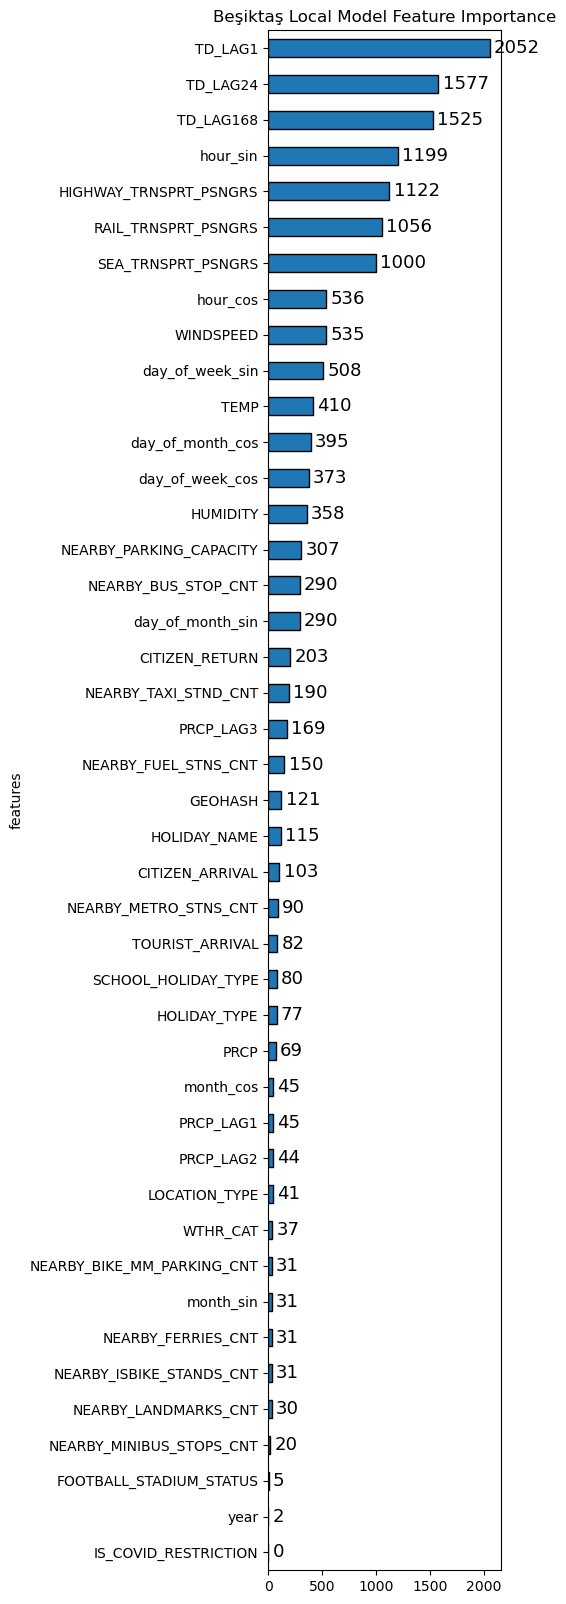



Silivri
Cross Validating.....

cv #1: RMSE = 9.975 | Time taken: 0.34 min
cv #2: RMSE = 8.947 | Time taken: 0.40 min
cv #3: RMSE = 8.471 | Time taken: 0.36 min
cv #4: RMSE = 8.540 | Time taken: 0.39 min
cv #5: RMSE = 8.475 | Time taken: 0.36 min

Average RMSE: 8.881 ± 0.57


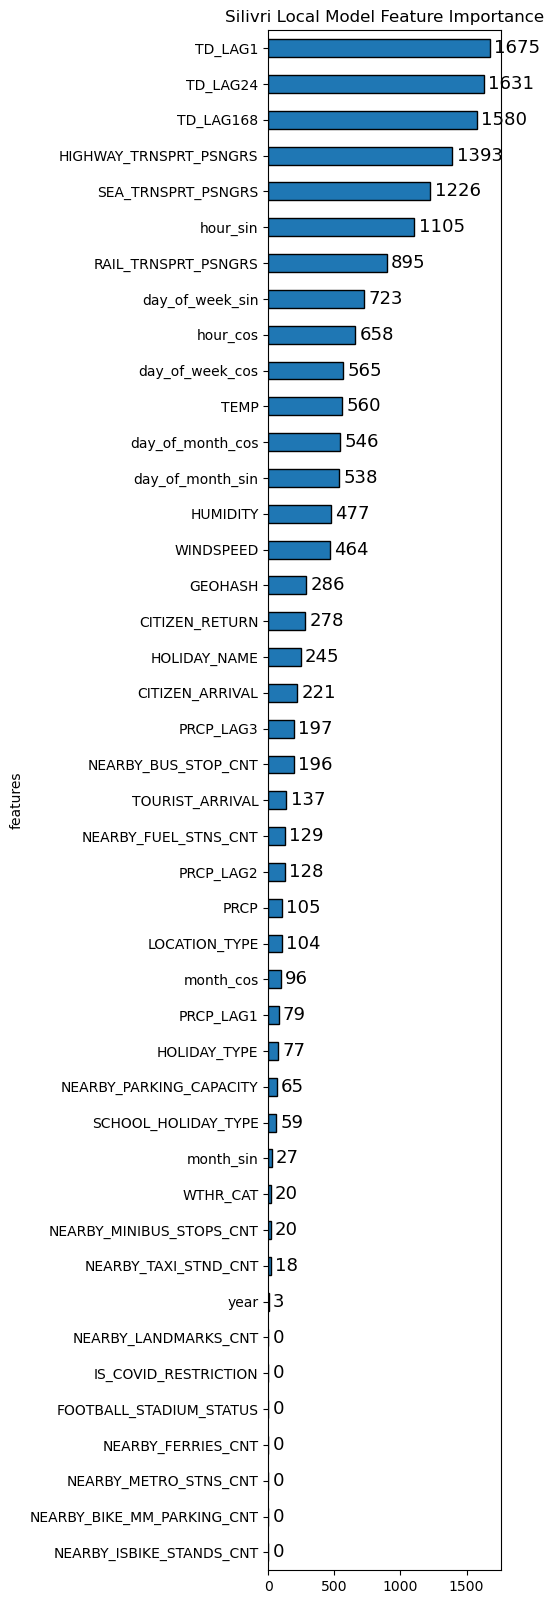

In [8]:
for district in ['Başakşehir', 'Beşiktaş', 'Silivri']:

    print(district)
    train = get_train(district)
    pipeline = create_pipeline(train=train)
    trained_pipeline = cv_train(pipeline=pipeline, train=train)
    
    plot_cv_results(pipeline=trained_pipeline, district=district)
    print()
    print()